In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel


/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Mon Jul 29 19:45:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   42C    P0    56W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

In [3]:
from datasets import load_dataset

# Load the dataset from the CSV file
dataset = load_dataset(
    'csv',
    data_files='dataset_semanticattribution_nerfeatures_split.csv',
    delimiter=',',
    column_names=[
        "claim", "premise", "label", "category", "count_bf", "count_ca", "count_dis",
        "count_food", "count_lipid", "count_treat", "pres_bf", "pres_ca", "pres_dis",
        "pres_food", "pres_lipid", "pres_treat", "counte_bf", "counte_ca", "counte_dis",
        "counte_food", "counte_lipid", "counte_treat", "prese_bf", "prese_ca", "prese_dis",
        "prese_food", "prese_lipid", "prese_treat", "url", "entities", "entity_map",
        "gold_exp", "gemini_exp", "gemini_label","entity_ev","entity_map_ev", "split"
    ],
    skiprows=1
)

# Assuming 'split' column contains strings 'train', 'validation', 'test'
# Filter the loaded dataset into subsets
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')

Using custom data configuration default-31dfe7adddcf5ced
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 228.41it/s]
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ad71be204b279b28.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e7b6b615907c24ca.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-bee802838a3bfaea.arrow


In [4]:
train_dataset

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gemini_exp', 'gemini_label', 'entity_ev', 'entity_map_ev', 'split'],
    num_rows: 1623
})

In [5]:
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

In [6]:
columns_to_keep = ['claim', 'premise', 'label','category','counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat']
all_columns = train_dataset.column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [7]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-192f7cd55308f437.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-628e09c96e321cd1.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-1df942f735662e2b.arrow


Label Encoding Mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [8]:
len(dataset['val']['claim'])

465

In [9]:
labels = np.array(dataset['train']['label'])

In [10]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        category = item['category'].lower()

        claim = item['claim'].lower() + "[" + category + "]"
        premise = item['premise'].lower().replace('\n', '').replace('[','').replace(']','')
        additional_features = [
            'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat']
    
        for feature in additional_features:
            if feature in item:
                premise += "[SEP]" + str(item[feature])
        item['claim']=claim
        item['premise']=premise        
        # Tokenize the texts
        inputs = self.tokenizer(
             premise, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': premise  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item




In [11]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [12]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model = model.to(device)

In [13]:
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [15]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
    num_rows: 1623
})

In [16]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [17]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [18]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [19]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [20]:
tdata.__getitem__(0)

{'input_ids': tensor([     1,   2600,   1655,  16876,    667,  15726,  61593,    261,   2030,
            260,    346,  15302,   6848,  15726,  61593,    261,    584,    260,
            346,  33770,    452,  15726,  61593,  16876,    667,  15726,  61593,
            261,    845,    260,    346,  14033,   2179,  24360,  34984,  15726,
          61593,    261,   1917,    260,    346,  51194,  73907,   8007,  15726,
          61593,    261,   2673,    260,    346,   1942,   3359,  73907,   8007,
          15726,  61593,    261,   4402,    260,  88609,    263,  98237,   1830,
           6725,    263,   5134,  30055,  77487,    532,   4014,    271,    547,
          52263,  16224,    265,  86207,  14178,    268,    260,  62713,   4379,
            261,    584,    260,  41529,  23399,    429,   8068,   1068,    268,
            265,  42543,    834,   1917, 110269,    287,    260, 116367,   2148,
            263,  25348,  20413,   1563,    265,    917,    263,    308,    266,
          84530

In [21]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

device = torch.device("cuda:0")

training_args = TrainingArguments(
    output_dir=f'/home/elson/2.2.4_deberta/',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to("cuda:0"),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)
print(f"Model is on device: {next(model.parameters()).device}")
# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/2.2.4_deberta/best_model')
tokenizer.save_pretrained(f'/home/elson/2.2.4_deberta/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1530


Model is on device: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.785600,0.830763,0.686022,0.409479,0.658793,0.686022,0.608740
2,0.554500,0.957075,0.643011,0.522457,0.675821,0.643011,0.655561
3,0.408300,1.121595,0.623656,0.497029,0.658601,0.623656,0.638566
4,0.201800,1.419068,0.660215,0.477465,0.653174,0.660215,0.653506
5,0.226900,1.481661,0.653763,0.503955,0.670282,0.653763,0.660856
6,0.103300,1.698185,0.625806,0.506377,0.670254,0.625806,0.644455
7,0.083700,2.132897,0.636559,0.495408,0.659698,0.636559,0.646957
8,0.153300,2.372413,0.638710,0.501332,0.653391,0.638710,0.645100
9,0.043100,2.543519,0.634409,0.482636,0.643346,0.634409,0.637329
10,0.010300,2.700744,0.643011,0.497400,0.662377,0.643011,0.651057


***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/2.2.4_deberta/checkpoint-102
Configuration saved in /home/elson/2.2.4_deberta/checkpoint-102/config.json
Model weights saved in /home/elson/2.2.4_deberta/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/2.2.4_deberta/checkpoint-204
Configuration saved in /home/elson/2.2.4_deberta/checkpoint-204/config.json
Model weights saved in /home/elson/2.2.4_deberta/checkpoint-204/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/2.2.4_deberta/checkpoint-306
Configuration saved in /home/elson/2.2.4_deberta/checkpoint-306/config.json
Model weights saved in /home/elson/2.2.4_deberta/checkpoint-306/pytorch_model.bin
Deleting older checkpoint [/home/elson/2.2.4_deberta/checkpoint-204] due to args.save_total_limit
***** Running 

Configuration saved in /home/elson/2.2.4_deberta/best_model/config.json
Model weights saved in /home/elson/2.2.4_deberta/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/2.2.4_deberta/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/2.2.4_deberta/best_model/special_tokens_map.json
added tokens file saved in /home/elson/2.2.4_deberta/best_model/added_tokens.json


('/home/elson/2.2.4_deberta/best_model/tokenizer_config.json',
 '/home/elson/2.2.4_deberta/best_model/special_tokens_map.json',
 '/home/elson/2.2.4_deberta/best_model/spm.model',
 '/home/elson/2.2.4_deberta/best_model/added_tokens.json')

In [22]:
model_path = "/home/elson/2.2.4_deberta/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/2.2.4_deberta/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/2.2.4_deberta/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,

In [23]:
print(test_results)

PredictionOutput(predictions=array([[-6.5820e-01,  1.2285e+00, -6.3721e-01],
       [-1.5488e+00,  2.1699e+00, -6.6211e-01],
       [-1.5498e+00,  2.4805e+00, -9.7705e-01],
       [-5.2100e-01,  1.4580e+00, -1.0195e+00],
       [-7.1484e-01,  1.6895e+00, -1.0273e+00],
       [-1.6758e+00,  2.7734e+00, -1.1934e+00],
       [-5.4590e-01,  1.5889e+00, -1.2188e+00],
       [-1.6045e+00,  2.4355e+00, -8.7305e-01],
       [-1.5791e+00,  2.5410e+00, -9.9561e-01],
       [-1.1572e+00,  2.3516e+00, -1.2764e+00],
       [-1.3359e+00,  2.3770e+00, -1.1338e+00],
       [-8.6475e-01,  1.9795e+00, -1.2500e+00],
       [-1.4121e+00,  2.3613e+00, -9.8389e-01],
       [-1.7803e+00,  2.7012e+00, -9.8584e-01],
       [-1.3262e+00,  2.1777e+00, -9.3311e-01],
       [-6.8018e-01,  1.3906e+00, -7.3535e-01],
       [-1.6416e+00,  1.8389e+00, -1.7712e-01],
       [-1.3584e+00,  1.9004e+00, -5.3564e-01],
       [-1.1133e+00,  2.0840e+00, -1.0654e+00],
       [-1.1357e+00,  2.0547e+00, -1.0088e+00],
       [-1.

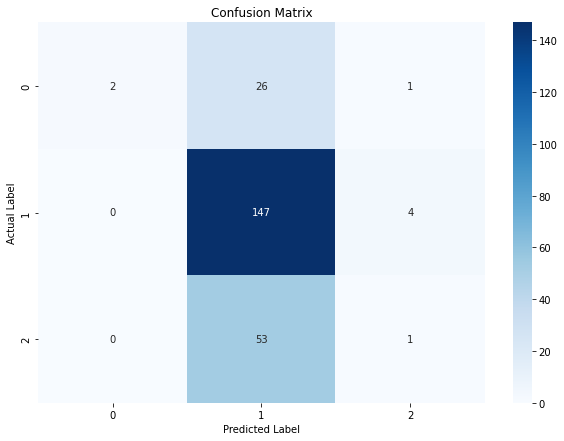

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [25]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/2.2.4_results.csv', index=False)

In [26]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [27]:
correct_classification_counts

General Health           34
Fitness                  13
Cancer                   12
Bone health              12
Skin                     10
Neurological health       9
Diabetes                  9
Hair                      9
Throat                    9
Ear                       6
Cardiovascular Health     6
COVID                     5
Eye                       5
Blood                     4
Muscles                   2
Women' s Health           2
Mental Health             2
Vascular                  1
Name: Category, dtype: int64

In [28]:
misclassification_counts

General Health           17
Skin                     14
Bone health               9
Cardiovascular Health     6
Men's health              6
Blood                     5
Muscles                   4
Women' s Health           4
Eye                       4
Diabetes                  3
Dental Health             3
Hair                      3
Fitness                   2
Vascular                  2
COVID                     1
Mental Health             1
Name: Category, dtype: int64